In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist= input_data.read_data_sets("./MNIST_data/", one_hot=True,reshape=False)
# mnist= input_data.read_data_sets("./Fashion-MNIST/", one_hot=True,reshape=False)
import matplotlib.pyplot as plt
from tensorflow.contrib.layers.python.layers import batch_norm

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting D:/HLK/mydata/try/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting D:/HLK/mydata/try/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting D:/HLK/mydata/try/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting D:/HLK/mydata/try/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
is_training=tf.concat(False,1)
def bnconv(x,filters,kernel_size=[3,3],strides=1,is_training=is_training, padding='same'):
    with tf.name_scope('bnconv'):
        x=tf.layers.conv2d(x,filters,kernel_size=kernel_size, strides=(strides, strides), padding=padding,use_bias=False)
        x=batch_norm(x,decay=0.99,updates_collections=None,is_training=is_training,activation_fn=tf.nn.leaky_relu)
        
    return x

def bndconv(x,filters,kernel_size=[3,3],strides=1,padding='same',is_training=is_training):
    with tf.name_scope('bndconv'):
        x=tf.layers.conv2d_transpose(x,filters,kernel_size=kernel_size, strides=(strides, strides), padding=padding,use_bias=False)
        x=batch_norm(x,decay=0.99,updates_collections=None,is_training=is_training,activation_fn=tf.nn.leaky_relu)
        
    return x

def generator(inputs):
    reuse=len([t for t in tf.global_variables() if t.name.startswith('generator')])>0
    with tf.variable_scope('generator',reuse=reuse):
        x=tf.reshape(inputs,[-1,1,1,42])
        x=bndconv(x,256,kernel_size=[3,3],strides=1,padding='valid')
        x=bndconv(x,128,kernel_size=[5,5],strides=1,padding='valid')
        x=bndconv(x,64,[5,5],strides=2)
        x=bndconv(x,64,[5,5])
        x=bndconv(x,64,[5,5],strides=2)
        x=bndconv(x,32,[5,5])
        x=tf.layers.conv2d(x,1,kernel_size=[5,5],strides=(1, 1), padding='same',activation=tf.nn.sigmoid)
        return x
    
    


def discriminator(image,y):
    reuse=len([t for t in tf.global_variables() if t.name.startswith('discriminator')])>0
    with tf.variable_scope('discriminator',reuse=reuse):
        y=tf.reshape(y,[-1,1,1,10])
        wy=tf.layers.dense(y,32)
        by=tf.layers.dense(y,32)
        x=tf.layers.conv2d(image,32,kernel_size=[3,3], strides=(1,1), padding='same')*wy+by
        x=tf.nn.leaky_relu(x)
        x=bnconv(x,64,[5,5])
        x=bnconv(x,64,[5,5],strides=2)
        x=bnconv(x,64,[5,5])
        x=bnconv(x,128,[5,5],strides=2)
        x=bnconv(x,128,[5,5])
        x=tf.layers.conv2d(x,1,kernel_size=[7,7],strides=(1, 1), padding='valid')
        x=tf.reshape(x,[-1,1])
    return x

In [3]:
batch_size=64
classes_dim=10
hidden_dim=32

number=np.array(np.arange(10)==[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]],dtype=np.float32)
n=np.ones([10,hidden_dim],dtype=np.float32)/2
test=np.append(number,n,axis=1)


x=tf.placeholder(tf.float32,[None,classes_dim+hidden_dim])
train_input = tf.placeholder(tf.float32,[batch_size, 28,28,1])
y =tf.placeholder(tf.float32,[batch_size,10])
noise=tf.random_normal([batch_size,hidden_dim],0.5,0.25)
input_message=tf.concat([y,noise],1)

In [4]:
output=generator(x)
gen=generator(input_message)
F_hid=discriminator(gen,y)
T_hid=discriminator(train_input,y)

In [5]:
t_vars=tf.trainable_variables()
d_vars=[var for var in t_vars if 'discriminator' in var.name]
g_vars=[var for var in t_vars if 'generator' in var.name]
d_clip = [tf.assign(var, tf.clip_by_value(var, -0.01, 0.01)) for var in d_vars]
loss_g=tf.reduce_mean(-F_hid)
loss_d=tf.reduce_mean(F_hid)+tf.reduce_mean(-T_hid)
rate=tf.concat(0.002,1)
train_disc=tf.train.RMSPropOptimizer(rate).minimize(loss_d,var_list=d_vars)
train_gen=tf.train.RMSPropOptimizer(rate).minimize(loss_g,var_list=g_vars)

In [6]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

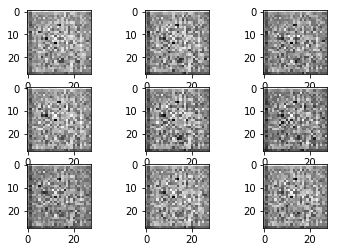

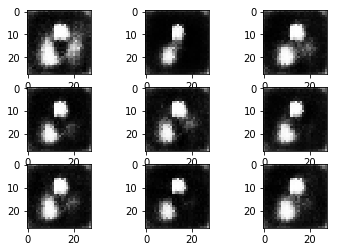

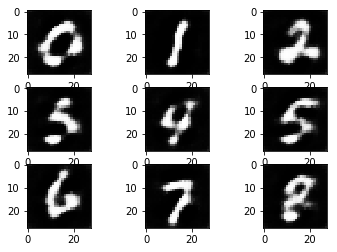

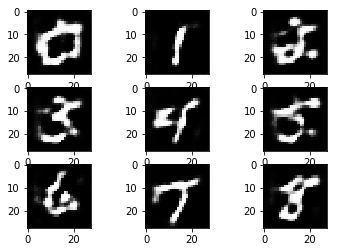

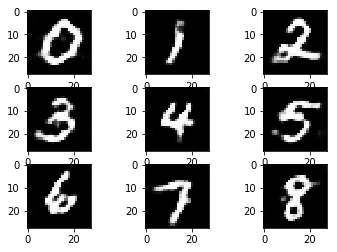

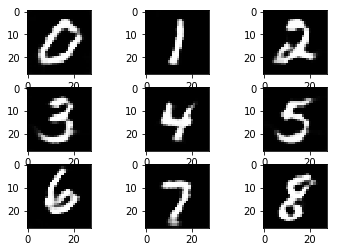

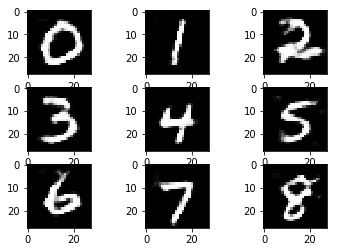

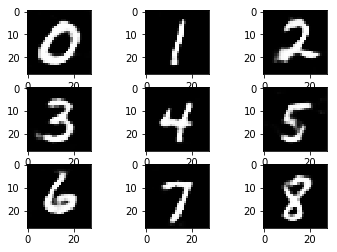

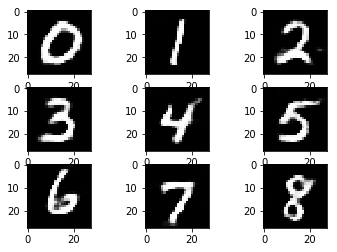

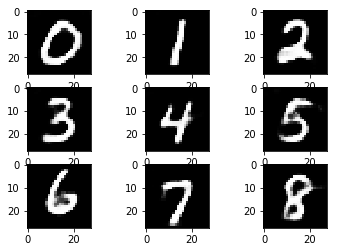

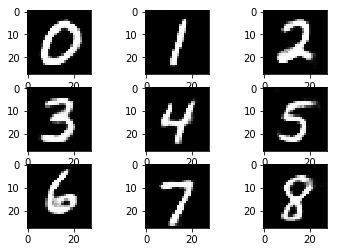

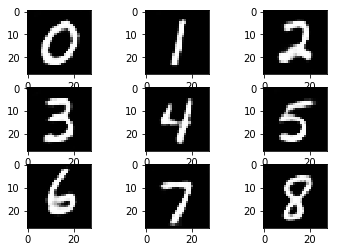

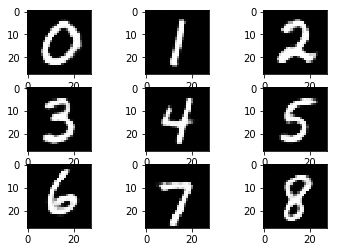

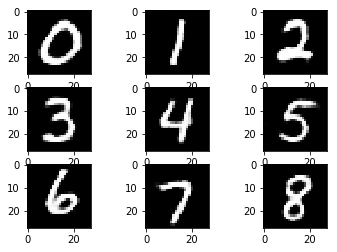

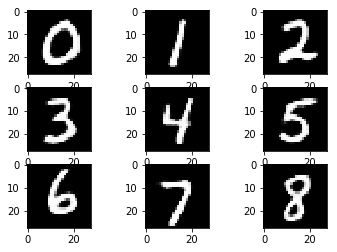

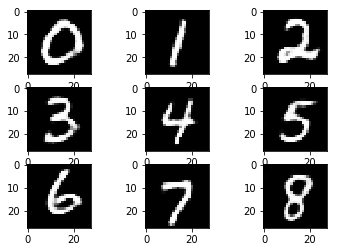

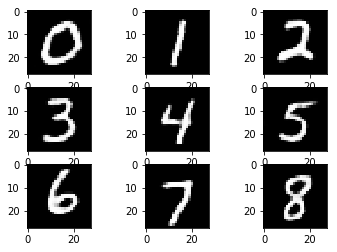

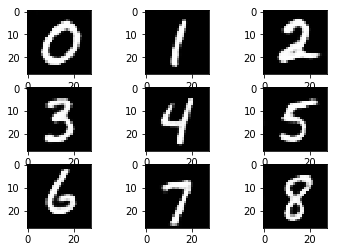

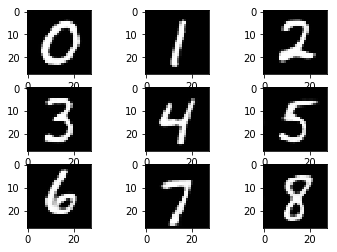

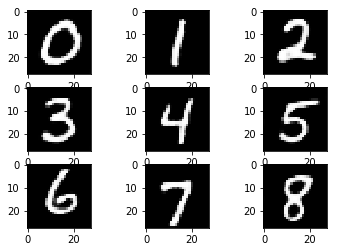

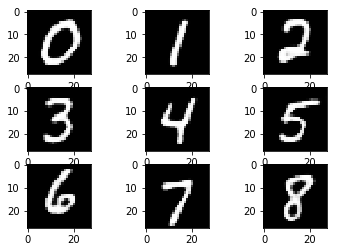

In [7]:
for i in range(20001):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    
    sess.run([train_disc,d_clip],{train_input:batch_xs,y:batch_ys,is_training:True,rate:0.0001})

    sess.run(train_gen,{train_input:batch_xs,y:batch_ys,is_training:True,rate:0.00001})

    if i%1000==0:
        images=sess.run(output,{x:test})
        for num,pic in enumerate(images[:-1]):
            plt.subplot(331+num)
            plt.imshow(pic.reshape(28,28),cmap='Greys_r')
        plt.show()

In [ ]:
saver=tf.train.Saver()
saver.save(sess,'./checkpoint/cWDCGAN')